# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch/Layer Normalization as a tool to more efficiently optimize deep networks.
  

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: foward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [3]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769847728806635e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [5]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [6]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)
print(x)
out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

[[-0.5        -0.40909091 -0.31818182 -0.22727273]
 [-0.13636364 -0.04545455  0.04545455  0.13636364]
 [ 0.22727273  0.31818182  0.40909091  0.5       ]]
Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [7]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1: 

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
1. Sigmoid.<br> 
    If input is a large negative or a positive number, sigmoid curve gets almost horizontal. In other words local gradient will become zero. During backpropagation, when this local gradient is multiplied, it will effectively “kill” the gradient.

2. ReLu <br>
    ReLu faces the similar problem. A large gradient flowing through a ReLU neuron could cause the weights to update in such a way that the neuron will never activate on any datapoint again 



# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [8]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))


Testing affine_relu_forward and affine_relu_backward:
dx error:  6.750562121603446e-11
dw error:  8.162015570444288e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `cs231n/layers.py`.

You can make sure that the implementations are correct by running the following:

In [9]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [26]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.22e-08
W2 relative error: 3.48e-10
b1 relative error: 6.55e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 8.18e-07
W2 relative error: 2.85e-08
b1 relative error: 1.09e-09
b2 relative error: 7.76e-10


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [29]:
model = TwoLayerNet()
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

_data = dict((k, data[k]) for k in ('X_train', 'y_train', 'X_val','y_val'))
solver = Solver(model, _data,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    lr_decay=0.95,
                    num_epochs=10, batch_size=100,
                    print_every=100)

solver.train()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.301628
(Epoch 0 / 10) train acc: 0.125000; val_acc: 0.131000
(Iteration 101 / 4900) loss: 1.696122
(Iteration 201 / 4900) loss: 1.668786
(Iteration 301 / 4900) loss: 1.654901
(Iteration 401 / 4900) loss: 1.522798
(Epoch 1 / 10) train acc: 0.472000; val_acc: 0.450000
(Iteration 501 / 4900) loss: 1.605058
(Iteration 601 / 4900) loss: 1.347041
(Iteration 701 / 4900) loss: 1.462147
(Iteration 801 / 4900) loss: 1.501644
(Iteration 901 / 4900) loss: 1.373416
(Epoch 2 / 10) train acc: 0.470000; val_acc: 0.473000
(Iteration 1001 / 4900) loss: 1.186980
(Iteration 1101 / 4900) loss: 1.296003
(Iteration 1201 / 4900) loss: 1.471242
(Iteration 1301 / 4900) loss: 1.505201
(Iteration 1401 / 4900) loss: 1.467081
(Epoch 3 / 10) train acc: 0.511000; val_acc: 0.492000
(Iteration 1501 / 4900) loss: 1.483155
(Iteration 1601 / 4900) loss: 1.173283
(Iteration 1701 / 4900) loss: 1.308485
(Iteration 1801 / 4900) loss: 1.355781
(Iteration 1901 / 4900) loss: 1.360393
(Epoch 4 / 10) t

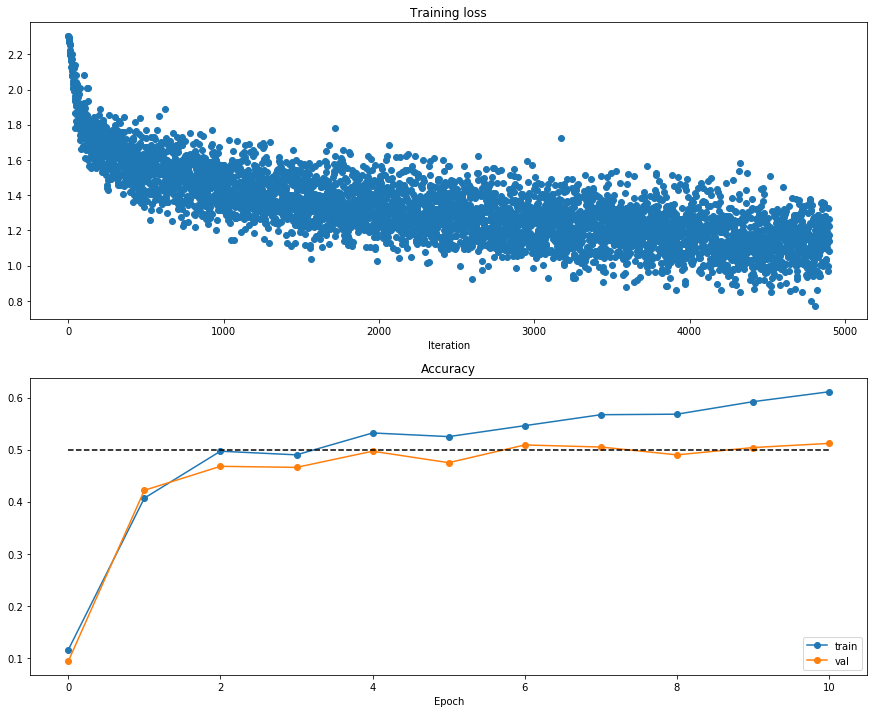

In [12]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch/layer normalization; we will add those features soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-7 or less.

In [13]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Most of the errors should be on the order of e-7 or smaller.   
  # NOTE: It is fine however to see an error for W2 on the order of e-5
  # for the check when reg = 0.0
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 6.86e-09
W2 relative error: 3.52e-08
W3 relative error: 1.32e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.80e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

0.0001760606252491018 0.020410652612934593
(Iteration 1 / 40) loss: 3.698011
(Epoch 0 / 20) train acc: 0.080000; val_acc: 0.099000
(Epoch 1 / 20) train acc: 0.080000; val_acc: 0.099000
(Epoch 2 / 20) train acc: 0.140000; val_acc: 0.108000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.110000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.115000
(Epoch 5 / 20) train acc: 0.200000; val_acc: 0.113000
(Iteration 11 / 40) loss: 2.138155
(Epoch 6 / 20) train acc: 0.240000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.240000; val_acc: 0.117000
(Epoch 8 / 20) train acc: 0.220000; val_acc: 0.114000
(Epoch 9 / 20) train acc: 0.220000; val_acc: 0.114000
(Epoch 10 / 20) train acc: 0.260000; val_acc: 0.120000
(Iteration 21 / 40) loss: 1.928686
(Epoch 11 / 20) train acc: 0.300000; val_acc: 0.121000
(Epoch 12 / 20) train acc: 0.280000; val_acc: 0.124000
(Epoch 13 / 20) train acc: 0.320000; val_acc: 0.125000
(Epoch 14 / 20) train acc: 0.340000; val_acc: 0.134000
(Epoch 15 / 20) train acc: 0.380000; v

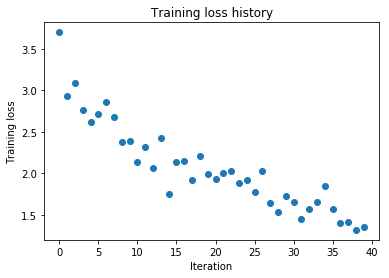

0.0002139529949593847 0.0032185430163898313
(Iteration 1 / 40) loss: 2.302689
(Epoch 0 / 20) train acc: 0.060000; val_acc: 0.090000
(Epoch 1 / 20) train acc: 0.060000; val_acc: 0.090000
(Epoch 2 / 20) train acc: 0.060000; val_acc: 0.091000
(Epoch 3 / 20) train acc: 0.060000; val_acc: 0.091000
(Epoch 4 / 20) train acc: 0.080000; val_acc: 0.090000
(Epoch 5 / 20) train acc: 0.080000; val_acc: 0.091000
(Iteration 11 / 40) loss: 2.301222
(Epoch 6 / 20) train acc: 0.080000; val_acc: 0.090000
(Epoch 7 / 20) train acc: 0.080000; val_acc: 0.086000
(Epoch 8 / 20) train acc: 0.080000; val_acc: 0.086000
(Epoch 9 / 20) train acc: 0.080000; val_acc: 0.085000
(Epoch 10 / 20) train acc: 0.080000; val_acc: 0.085000
(Iteration 21 / 40) loss: 2.301075
(Epoch 11 / 20) train acc: 0.080000; val_acc: 0.084000
(Epoch 12 / 20) train acc: 0.100000; val_acc: 0.081000
(Epoch 13 / 20) train acc: 0.100000; val_acc: 0.082000
(Epoch 14 / 20) train acc: 0.100000; val_acc: 0.080000
(Epoch 15 / 20) train acc: 0.100000; 

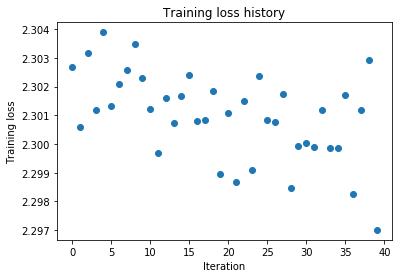

0.0008013698121810494 0.00091438758699036
(Iteration 1 / 40) loss: 2.302617
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.110000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.109000
(Epoch 2 / 20) train acc: 0.180000; val_acc: 0.098000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.108000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 11 / 40) loss: 2.302434
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.200000; val_acc: 0.124000
(Iteration 21 / 40) loss: 2.302248
(Epoch 11 / 20) train acc: 0.220000; val_acc: 0.115000
(Epoch 12 / 20) train acc: 0.200000; val_acc: 0.116000
(Epoch 13 / 20) train acc: 0.200000; val_acc: 0.115000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 15 / 20) train acc: 0.220000; va

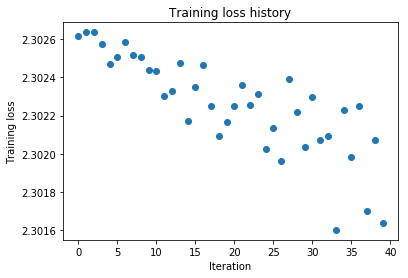

0.007460872912683157 0.017088552857504866
(Iteration 1 / 40) loss: 2.516912
(Epoch 0 / 20) train acc: 0.360000; val_acc: 0.124000
(Epoch 1 / 20) train acc: 0.520000; val_acc: 0.139000
(Epoch 2 / 20) train acc: 0.540000; val_acc: 0.134000
(Epoch 3 / 20) train acc: 0.720000; val_acc: 0.170000
(Epoch 4 / 20) train acc: 0.880000; val_acc: 0.192000
(Epoch 5 / 20) train acc: 0.880000; val_acc: 0.152000
(Iteration 11 / 40) loss: 0.548974
(Epoch 6 / 20) train acc: 0.980000; val_acc: 0.199000
(Epoch 7 / 20) train acc: 0.940000; val_acc: 0.175000
(Epoch 8 / 20) train acc: 0.980000; val_acc: 0.169000
(Epoch 9 / 20) train acc: 0.960000; val_acc: 0.172000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.189000
(Iteration 21 / 40) loss: 0.076012
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.186000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.183000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.184000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.183000
(Epoch 15 / 20) train acc: 1.000000; va

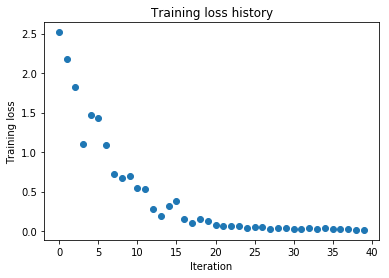

1.574056416610647e-05 1.6539811883593112e-05
(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 11 / 40) loss: 2.302584
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.082000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.082000
(Iteration 21 / 40) loss: 2.302579
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.160000;

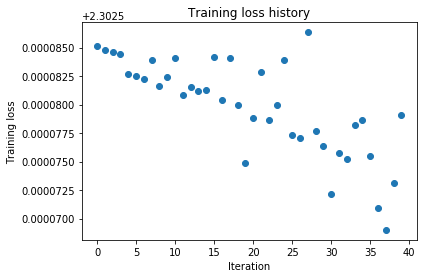

0.0006388789337932952 0.0001830543045175748
(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.140000; val_acc: 0.116000
(Epoch 1 / 20) train acc: 0.100000; val_acc: 0.076000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 11 / 40) loss: 2.302500
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 21 / 40) loss: 2.302378
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.160000; 

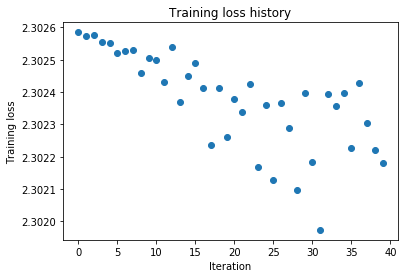

0.0007075984091383042 0.028812458792760415
(Iteration 1 / 40) loss: 4.398363
(Epoch 0 / 20) train acc: 0.300000; val_acc: 0.099000
(Epoch 1 / 20) train acc: 0.340000; val_acc: 0.091000
(Epoch 2 / 20) train acc: 0.520000; val_acc: 0.104000
(Epoch 3 / 20) train acc: 0.600000; val_acc: 0.109000
(Epoch 4 / 20) train acc: 0.700000; val_acc: 0.111000
(Epoch 5 / 20) train acc: 0.760000; val_acc: 0.118000
(Iteration 11 / 40) loss: 1.271154
(Epoch 6 / 20) train acc: 0.820000; val_acc: 0.117000
(Epoch 7 / 20) train acc: 0.860000; val_acc: 0.121000
(Epoch 8 / 20) train acc: 0.880000; val_acc: 0.118000
(Epoch 9 / 20) train acc: 0.880000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.920000; val_acc: 0.121000
(Iteration 21 / 40) loss: 0.507500
(Epoch 11 / 20) train acc: 0.940000; val_acc: 0.136000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.128000
(Epoch 13 / 20) train acc: 0.980000; val_acc: 0.121000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.127000
(Epoch 15 / 20) train acc: 1.000000; v

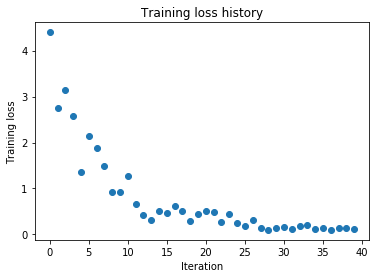

0.0003342898120144726 0.012070586848855872
(Iteration 1 / 40) loss: 2.318536
(Epoch 0 / 20) train acc: 0.140000; val_acc: 0.096000
(Epoch 1 / 20) train acc: 0.180000; val_acc: 0.100000
(Epoch 2 / 20) train acc: 0.180000; val_acc: 0.102000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.105000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.111000
(Epoch 5 / 20) train acc: 0.180000; val_acc: 0.114000
(Iteration 11 / 40) loss: 2.077135
(Epoch 6 / 20) train acc: 0.200000; val_acc: 0.113000
(Epoch 7 / 20) train acc: 0.200000; val_acc: 0.118000
(Epoch 8 / 20) train acc: 0.200000; val_acc: 0.118000
(Epoch 9 / 20) train acc: 0.220000; val_acc: 0.124000
(Epoch 10 / 20) train acc: 0.260000; val_acc: 0.124000
(Iteration 21 / 40) loss: 1.998642
(Epoch 11 / 20) train acc: 0.260000; val_acc: 0.119000
(Epoch 12 / 20) train acc: 0.260000; val_acc: 0.117000
(Epoch 13 / 20) train acc: 0.300000; val_acc: 0.118000
(Epoch 14 / 20) train acc: 0.300000; val_acc: 0.118000
(Epoch 15 / 20) train acc: 0.340000; v

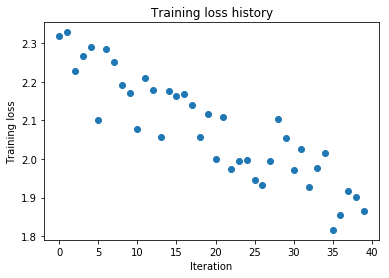

0.004115520332307658 3.2052406822165586e-05
(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 3 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 11 / 40) loss: 2.301851
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.300925
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.160000; 

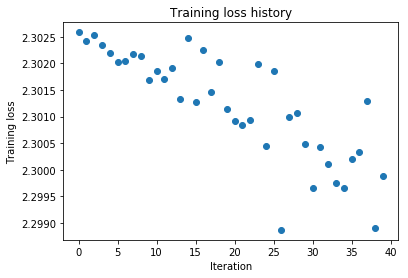

0.00016555208245034846 0.00019604395444546417
(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.082000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 11 / 40) loss: 2.302522
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.302527
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 15 / 20) train acc: 0.160000

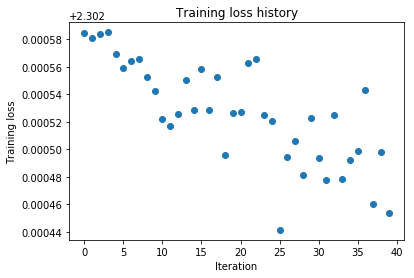

In [79]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

# for training accuracy 100. Found using the commented loop below.

weight_scale = 0.025312877398442724  # Experiment with this!
learning_rate = 0.0026035863194912843  # Experiment with this!

for i in range(10):
    learning_rate = 10**np.random.uniform(-5,-1)
    weight_scale = 10**np.random.uniform(-5,-1)

    print(learning_rate, weight_scale)
    model = FullyConnectedNet([100, 100],
                  weight_scale=weight_scale, dtype=np.float64)
    solver = Solver(model, small_data,
                    print_every=10, num_epochs=20, batch_size=25,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': learning_rate,
                    }
             )
    solver.train()

    plt.plot(solver.loss_history, 'o')
    plt.title('Training loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Training loss')
    plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

7.330073556396028e-05 0.0008165052507680692
(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.100000; val_acc: 0.078000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 2 / 20) train acc: 0.120000; val_acc: 0.093000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.073000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 11 / 40) loss: 2.302566
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.302546
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.160000; 

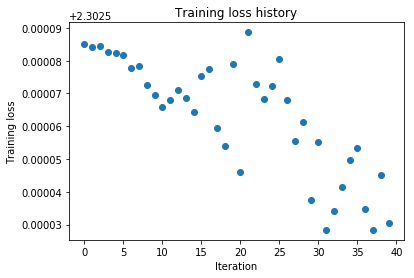

5.997894914602414e-05 0.015407812907542484
(Iteration 1 / 40) loss: 2.302334
(Epoch 0 / 20) train acc: 0.120000; val_acc: 0.136000
(Epoch 1 / 20) train acc: 0.120000; val_acc: 0.136000
(Epoch 2 / 20) train acc: 0.120000; val_acc: 0.136000
(Epoch 3 / 20) train acc: 0.120000; val_acc: 0.136000
(Epoch 4 / 20) train acc: 0.120000; val_acc: 0.135000
(Epoch 5 / 20) train acc: 0.120000; val_acc: 0.135000
(Iteration 11 / 40) loss: 2.301291
(Epoch 6 / 20) train acc: 0.120000; val_acc: 0.135000
(Epoch 7 / 20) train acc: 0.120000; val_acc: 0.135000
(Epoch 8 / 20) train acc: 0.120000; val_acc: 0.135000
(Epoch 9 / 20) train acc: 0.120000; val_acc: 0.134000
(Epoch 10 / 20) train acc: 0.120000; val_acc: 0.134000
(Iteration 21 / 40) loss: 2.300655
(Epoch 11 / 20) train acc: 0.120000; val_acc: 0.134000
(Epoch 12 / 20) train acc: 0.120000; val_acc: 0.134000
(Epoch 13 / 20) train acc: 0.120000; val_acc: 0.134000
(Epoch 14 / 20) train acc: 0.120000; val_acc: 0.134000
(Epoch 15 / 20) train acc: 0.120000; v

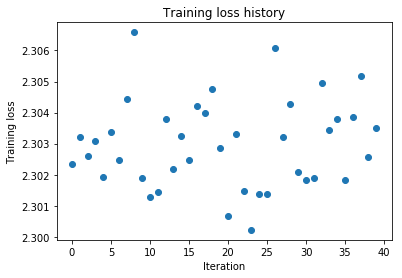

0.003657486335379352 4.47731345403299e-05
(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 11 / 40) loss: 2.301991
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.301483
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 15 / 20) train acc: 0.160000; va

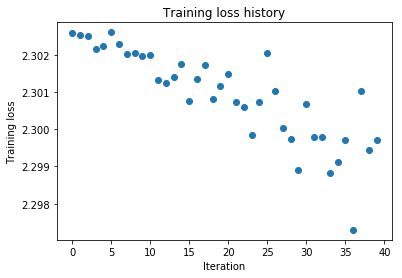

0.024611775256944066 0.00012982763659120084
(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 11 / 40) loss: 2.291742
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.293425
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.160000; 

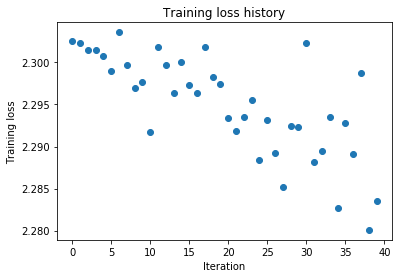

3.515133772435824e-05 0.00011657747837524669
(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.080000
(Epoch 1 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 11 / 40) loss: 2.302581
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.302569
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.160000;

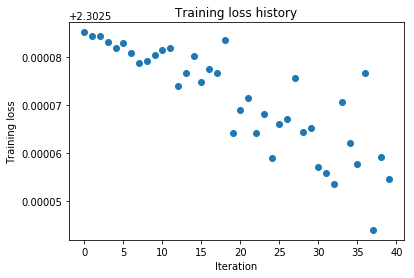

0.00013452994846652628 0.029796525982098854
(Iteration 1 / 40) loss: 2.375036
(Epoch 0 / 20) train acc: 0.060000; val_acc: 0.096000
(Epoch 1 / 20) train acc: 0.060000; val_acc: 0.096000
(Epoch 2 / 20) train acc: 0.060000; val_acc: 0.097000
(Epoch 3 / 20) train acc: 0.060000; val_acc: 0.096000
(Epoch 4 / 20) train acc: 0.060000; val_acc: 0.096000
(Epoch 5 / 20) train acc: 0.060000; val_acc: 0.096000
(Iteration 11 / 40) loss: 2.362263
(Epoch 6 / 20) train acc: 0.060000; val_acc: 0.096000
(Epoch 7 / 20) train acc: 0.060000; val_acc: 0.096000
(Epoch 8 / 20) train acc: 0.060000; val_acc: 0.094000
(Epoch 9 / 20) train acc: 0.060000; val_acc: 0.094000
(Epoch 10 / 20) train acc: 0.060000; val_acc: 0.093000
(Iteration 21 / 40) loss: 2.304149
(Epoch 11 / 20) train acc: 0.060000; val_acc: 0.093000
(Epoch 12 / 20) train acc: 0.060000; val_acc: 0.094000
(Epoch 13 / 20) train acc: 0.060000; val_acc: 0.093000
(Epoch 14 / 20) train acc: 0.060000; val_acc: 0.092000
(Epoch 15 / 20) train acc: 0.060000; 

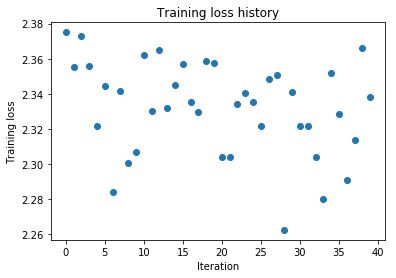

0.0001974564105542218 0.051242504034237205
(Iteration 1 / 40) loss: 4.091407
(Epoch 0 / 20) train acc: 0.140000; val_acc: 0.080000
(Epoch 1 / 20) train acc: 0.140000; val_acc: 0.081000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.080000
(Epoch 3 / 20) train acc: 0.200000; val_acc: 0.080000
(Epoch 4 / 20) train acc: 0.260000; val_acc: 0.084000
(Epoch 5 / 20) train acc: 0.320000; val_acc: 0.082000
(Iteration 11 / 40) loss: 2.303920
(Epoch 6 / 20) train acc: 0.300000; val_acc: 0.084000
(Epoch 7 / 20) train acc: 0.320000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.360000; val_acc: 0.082000
(Epoch 9 / 20) train acc: 0.420000; val_acc: 0.087000
(Epoch 10 / 20) train acc: 0.420000; val_acc: 0.101000
(Iteration 21 / 40) loss: 1.782757
(Epoch 11 / 20) train acc: 0.420000; val_acc: 0.093000
(Epoch 12 / 20) train acc: 0.460000; val_acc: 0.101000
(Epoch 13 / 20) train acc: 0.440000; val_acc: 0.102000
(Epoch 14 / 20) train acc: 0.480000; val_acc: 0.101000
(Epoch 15 / 20) train acc: 0.500000; v

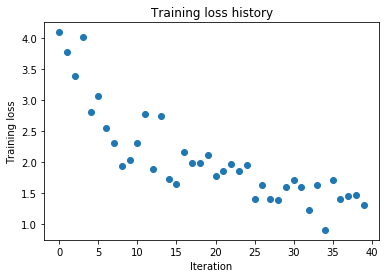

0.04215707025305571 5.59741760731193e-05
(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 11 / 40) loss: 2.292386
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.291794
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 15 / 20) train acc: 0.160000; val

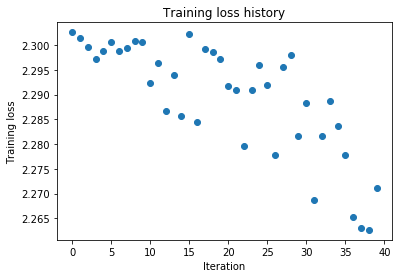

0.0034955030857726386 0.024640674658288675
(Iteration 1 / 40) loss: 2.306075
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.106000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.109000
(Epoch 2 / 20) train acc: 0.200000; val_acc: 0.114000
(Epoch 3 / 20) train acc: 0.180000; val_acc: 0.115000
(Epoch 4 / 20) train acc: 0.220000; val_acc: 0.121000
(Epoch 5 / 20) train acc: 0.260000; val_acc: 0.123000
(Iteration 11 / 40) loss: 2.266240
(Epoch 6 / 20) train acc: 0.220000; val_acc: 0.127000
(Epoch 7 / 20) train acc: 0.220000; val_acc: 0.129000
(Epoch 8 / 20) train acc: 0.280000; val_acc: 0.132000
(Epoch 9 / 20) train acc: 0.300000; val_acc: 0.134000
(Epoch 10 / 20) train acc: 0.300000; val_acc: 0.131000
(Iteration 21 / 40) loss: 2.238787
(Epoch 11 / 20) train acc: 0.320000; val_acc: 0.135000
(Epoch 12 / 20) train acc: 0.300000; val_acc: 0.146000
(Epoch 13 / 20) train acc: 0.320000; val_acc: 0.149000
(Epoch 14 / 20) train acc: 0.340000; val_acc: 0.141000
(Epoch 15 / 20) train acc: 0.340000; v

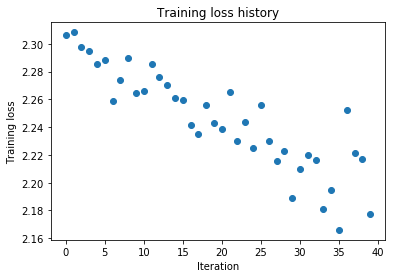

0.0024688943317818304 0.017226114560506697
(Iteration 1 / 40) loss: 2.309034
(Epoch 0 / 20) train acc: 0.140000; val_acc: 0.106000
(Epoch 1 / 20) train acc: 0.140000; val_acc: 0.106000
(Epoch 2 / 20) train acc: 0.140000; val_acc: 0.110000
(Epoch 3 / 20) train acc: 0.140000; val_acc: 0.115000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.116000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.125000
(Iteration 11 / 40) loss: 2.307158
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.123000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.128000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.127000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.129000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.129000
(Iteration 21 / 40) loss: 2.294013
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.129000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.130000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.130000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.132000
(Epoch 15 / 20) train acc: 0.160000; v

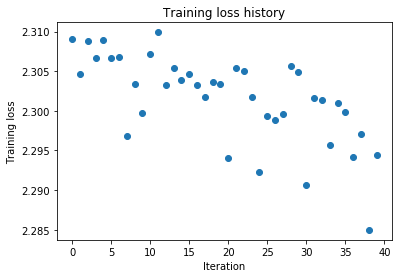

0.0014249087088752692 2.279776764486843e-05
(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 11 / 40) loss: 2.302230
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 21 / 40) loss: 2.301971
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.160000; 

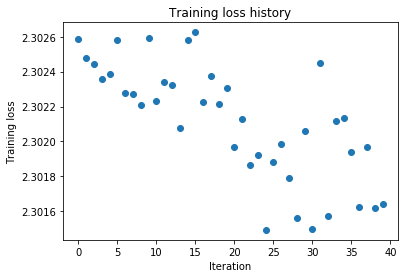

0.0631214364046788 0.08201432254742227
(Iteration 1 / 40) loss: 41.802705
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 2 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 3 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 4 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 5 / 20) train acc: 0.080000; val_acc: 0.087000
(Iteration 11 / 40) loss: nan
(Epoch 6 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 7 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 8 / 20) train acc: 0.080000; val_acc: 0.087000


/Users/hamzaliaqet/Downloads/code/cs233n/assignment2/cs231n/layers.py:810: RuntimeWarning: invalid value encountered in subtract
  shifted_logits = x - np.max(x, axis=1, keepdims=True)
/Users/hamzaliaqet/Downloads/code/cs233n/assignment2/cs231n/layers.py:106: RuntimeWarning: invalid value encountered in greater
  out = x * (x>0)
/Users/hamzaliaqet/Downloads/code/cs233n/assignment2/cs231n/layers.py:133: RuntimeWarning: invalid value encountered in greater
  dx = dout * (x>0)


(Epoch 9 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 10 / 20) train acc: 0.080000; val_acc: 0.087000
(Iteration 21 / 40) loss: nan
(Epoch 11 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 12 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 13 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 14 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 15 / 20) train acc: 0.080000; val_acc: 0.087000
(Iteration 31 / 40) loss: nan
(Epoch 16 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 17 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 18 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 19 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 20 / 20) train acc: 0.080000; val_acc: 0.087000


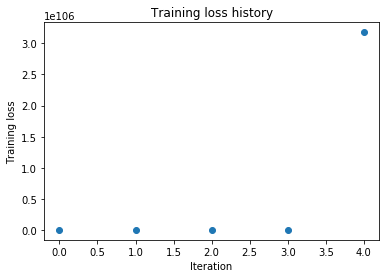

0.020365024044225223 1.1807710645612573e-05
(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 1 / 20) train acc: 0.120000; val_acc: 0.119000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 3 / 20) train acc: 0.120000; val_acc: 0.119000
(Epoch 4 / 20) train acc: 0.120000; val_acc: 0.119000
(Epoch 5 / 20) train acc: 0.120000; val_acc: 0.119000
(Iteration 11 / 40) loss: 2.297727
(Epoch 6 / 20) train acc: 0.120000; val_acc: 0.119000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.290004
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 15 / 20) train acc: 0.160000; 

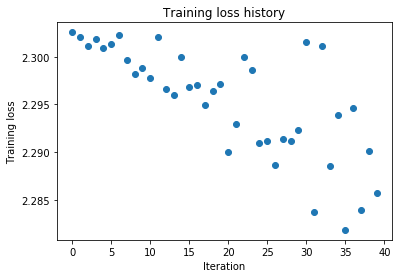

0.016125746644364974 1.9039324457358142e-05
(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.100000; val_acc: 0.078000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 11 / 40) loss: 2.299920
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 21 / 40) loss: 2.301589
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.160000; 

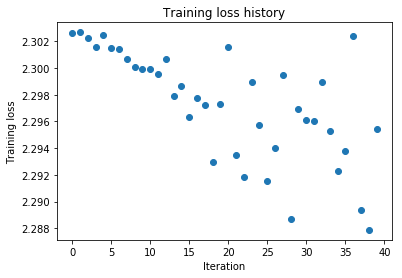

1.8459780032088604e-05 0.05268789682628402
(Iteration 1 / 40) loss: 4.250664
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.100000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.100000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.098000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.099000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.096000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.096000
(Iteration 11 / 40) loss: 3.419016
(Epoch 6 / 20) train acc: 0.180000; val_acc: 0.099000
(Epoch 7 / 20) train acc: 0.180000; val_acc: 0.099000
(Epoch 8 / 20) train acc: 0.200000; val_acc: 0.098000
(Epoch 9 / 20) train acc: 0.220000; val_acc: 0.098000
(Epoch 10 / 20) train acc: 0.220000; val_acc: 0.096000
(Iteration 21 / 40) loss: 2.822573
(Epoch 11 / 20) train acc: 0.220000; val_acc: 0.097000
(Epoch 12 / 20) train acc: 0.220000; val_acc: 0.097000
(Epoch 13 / 20) train acc: 0.220000; val_acc: 0.096000
(Epoch 14 / 20) train acc: 0.240000; val_acc: 0.096000
(Epoch 15 / 20) train acc: 0.220000; v

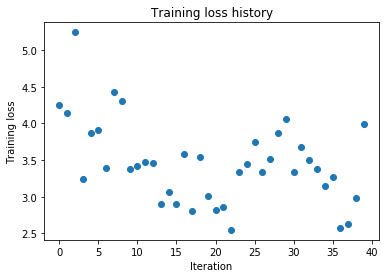

0.009786991580908642 0.0006138673316353064
(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 11 / 40) loss: 2.301426
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.298541
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 15 / 20) train acc: 0.160000; v

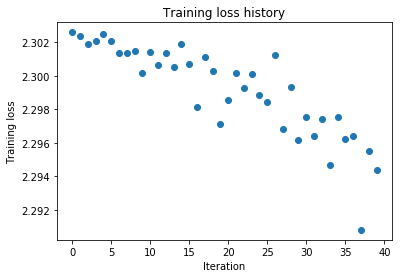

0.0011135494307641706 3.497988593572784e-05
(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.120000; val_acc: 0.119000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 11 / 40) loss: 2.302416
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 21 / 40) loss: 2.302180
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.160000; 

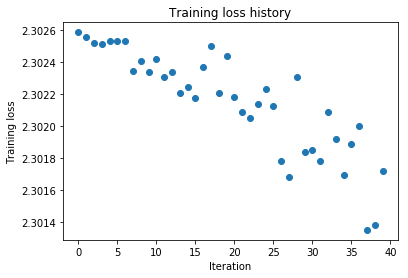

0.004937805333583935 0.0001341546749868874
(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 11 / 40) loss: 2.301052
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.300147
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 15 / 20) train acc: 0.160000; v

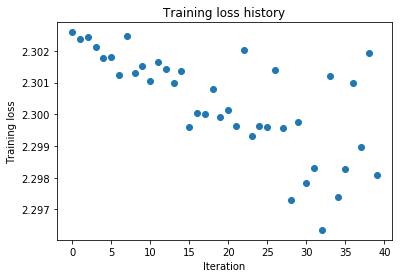

0.01371898447528723 0.06128171234508055
(Iteration 1 / 40) loss: 9.673202
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.113000
(Epoch 1 / 20) train acc: 0.080000; val_acc: 0.130000
(Epoch 2 / 20) train acc: 0.080000; val_acc: 0.091000
(Epoch 3 / 20) train acc: 0.300000; val_acc: 0.077000
(Epoch 4 / 20) train acc: 0.460000; val_acc: 0.097000
(Epoch 5 / 20) train acc: 0.580000; val_acc: 0.109000
(Iteration 11 / 40) loss: 1.567313
(Epoch 6 / 20) train acc: 0.720000; val_acc: 0.128000
(Epoch 7 / 20) train acc: 0.860000; val_acc: 0.126000
(Epoch 8 / 20) train acc: 0.880000; val_acc: 0.119000
(Epoch 9 / 20) train acc: 0.900000; val_acc: 0.128000
(Epoch 10 / 20) train acc: 0.940000; val_acc: 0.118000
(Iteration 21 / 40) loss: 0.508291
(Epoch 11 / 20) train acc: 0.900000; val_acc: 0.125000
(Epoch 12 / 20) train acc: 0.920000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.960000; val_acc: 0.110000
(Epoch 14 / 20) train acc: 0.960000; val_acc: 0.112000
(Epoch 15 / 20) train acc: 0.800000; val_

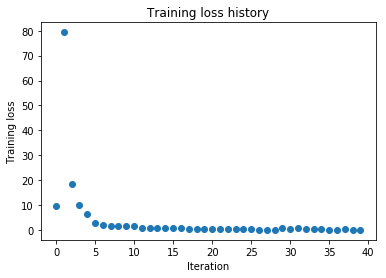

0.0010711123700168168 0.0012064868588805631
(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 11 / 40) loss: 2.302491
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.302089
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 15 / 20) train acc: 0.160000; 

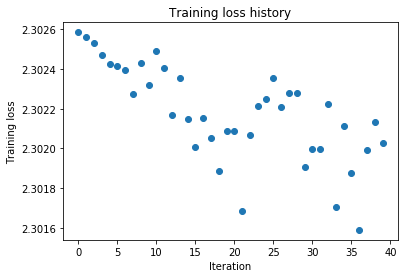

In [15]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}


for i in range(20):
    learning_rate = 10**np.random.uniform(-5,-1)
    weight_scale = 10**np.random.uniform(-5,-1)
    print(learning_rate, weight_scale)
# learning_rate = 2e-3  # Experiment with this!
# weight_scale = 1e-5   # Experiment with this!
    model = FullyConnectedNet([100, 100, 100, 100],
                    weight_scale=weight_scale, dtype=np.float64)
    solver = Solver(model, small_data,
                    print_every=10, num_epochs=20, batch_size=25,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': learning_rate,
                    }
             )
    solver.train()

    plt.plot(solver.loss_history, 'o')
    plt.title('Training loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Training loss')
    plt.show()



## Inline Question 2: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:
Training 5 layer net is more difficult.

# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [18]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
(Iteration 1 / 200) loss: 2.693789
(Epoch 0 / 5) train acc: 0.075000; val_acc: 0.109000
(Iteration 11 / 200) loss: 2.350427
(Iteration 21 / 200) loss: 2.164649
(Iteration 31 / 200) loss: 2.148723
(Epoch 1 / 5) train acc: 0.227000; val_acc: 0.192000
(Iteration 41 / 200) loss: 2.075424
(Iteration 51 / 200) loss: 2.045286
(Iteration 61 / 200) loss: 1.992742
(Iteration 71 / 200) loss: 2.003836
(Epoch 2 / 5) train acc: 0.243000; val_acc: 0.217000
(Iteration 81 / 200) loss: 2.014032
(Iteration 91 / 200) loss: 1.894023
(Iteration 101 / 200) loss: 1.975518
(Iteration 111 / 200) loss: 2.018149
(Epoch 3 / 5) train acc: 0.314000; val_acc: 0.255000
(Iteration 121 / 200) loss: 1.890719
(Iteration 131 / 200) loss: 1.920991
(Iteration 141 / 200) loss: 1.950544
(Iteration 151 / 200) loss: 1.795708
(Epoch 4 / 5) train acc: 0.335000; val_acc: 0.275000
(Iteration 161 / 200) loss: 1.742409
(Iteration 171 / 200) loss: 1.854194
(Iteration 181 / 200) loss: 1.719835
(Iteration 191 / 200) los

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


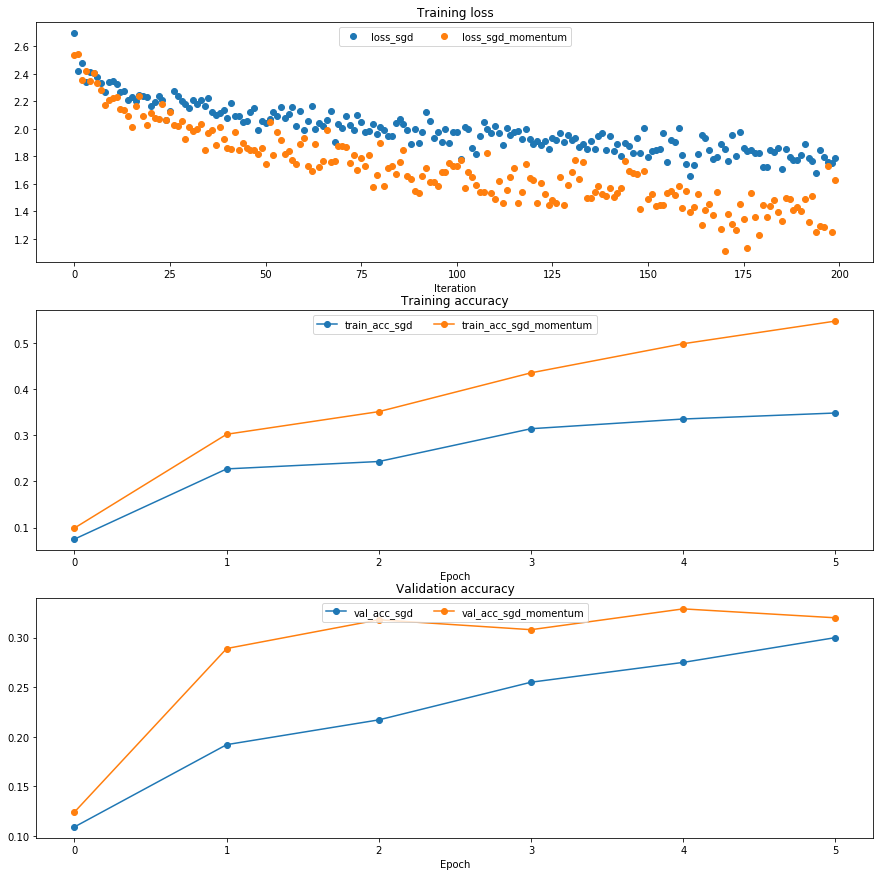

In [19]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes. 

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [27]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [77]:
# Test Adam implementation
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
# print(next_w)
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

running with  adam
(Iteration 1 / 200) loss: 2.476411
(Epoch 0 / 5) train acc: 0.128000; val_acc: 0.126000
(Iteration 11 / 200) loss: 2.094781


/Users/hamzaliaqet/Downloads/code/cs233n/assignment2/cs231n/optim.py:161: RuntimeWarning: invalid value encountered in sqrt
  w += -config['learning_rate'] * m / (np.sqrt(v) + config['epsilon'])


(Iteration 21 / 200) loss: 2.016507
(Iteration 31 / 200) loss: 1.707863
(Epoch 1 / 5) train acc: 0.405000; val_acc: 0.317000
(Iteration 41 / 200) loss: 1.867838
(Iteration 51 / 200) loss: 1.738649
(Iteration 61 / 200) loss: 1.636723
(Iteration 71 / 200) loss: 1.765054
(Epoch 2 / 5) train acc: 0.417000; val_acc: 0.346000
(Iteration 81 / 200) loss: 1.564045
(Iteration 91 / 200) loss: 1.850417
(Iteration 101 / 200) loss: 1.634480
(Iteration 111 / 200) loss: 1.301676
(Epoch 3 / 5) train acc: 0.467000; val_acc: 0.366000
(Iteration 121 / 200) loss: 1.460827
(Iteration 131 / 200) loss: 1.428216
(Iteration 141 / 200) loss: 1.536207
(Iteration 151 / 200) loss: 1.238169
(Epoch 4 / 5) train acc: 0.510000; val_acc: 0.355000
(Iteration 161 / 200) loss: 1.455518
(Iteration 171 / 200) loss: 1.599862
(Iteration 181 / 200) loss: 1.093596
(Iteration 191 / 200) loss: 1.208353
(Epoch 5 / 5) train acc: 0.592000; val_acc: 0.378000

running with  rmsprop
(Iteration 1 / 200) loss: 2.562221
(Epoch 0 / 5) train

/Users/hamzaliaqet/Downloads/code/cs233n/assignment2/cs231n/optim.py:112: RuntimeWarning: invalid value encountered in sqrt
  w += -config['learning_rate'] * dw / (np.sqrt(config['cache']) + config['epsilon'])


(Epoch 1 / 5) train acc: 0.361000; val_acc: 0.306000
(Iteration 41 / 200) loss: 1.790461
(Iteration 51 / 200) loss: 1.738327
(Iteration 61 / 200) loss: 1.803470
(Iteration 71 / 200) loss: 1.693542
(Epoch 2 / 5) train acc: 0.462000; val_acc: 0.333000
(Iteration 81 / 200) loss: 1.590299
(Iteration 91 / 200) loss: 1.537307
(Iteration 101 / 200) loss: 1.502768
(Iteration 111 / 200) loss: 1.508932
(Epoch 3 / 5) train acc: 0.445000; val_acc: 0.361000
(Iteration 121 / 200) loss: 1.484976
(Iteration 131 / 200) loss: 1.452010
(Iteration 141 / 200) loss: 1.532547
(Iteration 151 / 200) loss: 1.531311
(Epoch 4 / 5) train acc: 0.524000; val_acc: 0.355000
(Iteration 161 / 200) loss: 1.444502
(Iteration 171 / 200) loss: 1.469551
(Iteration 181 / 200) loss: 1.442853
(Iteration 191 / 200) loss: 1.349835
(Epoch 5 / 5) train acc: 0.537000; val_acc: 0.372000



/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


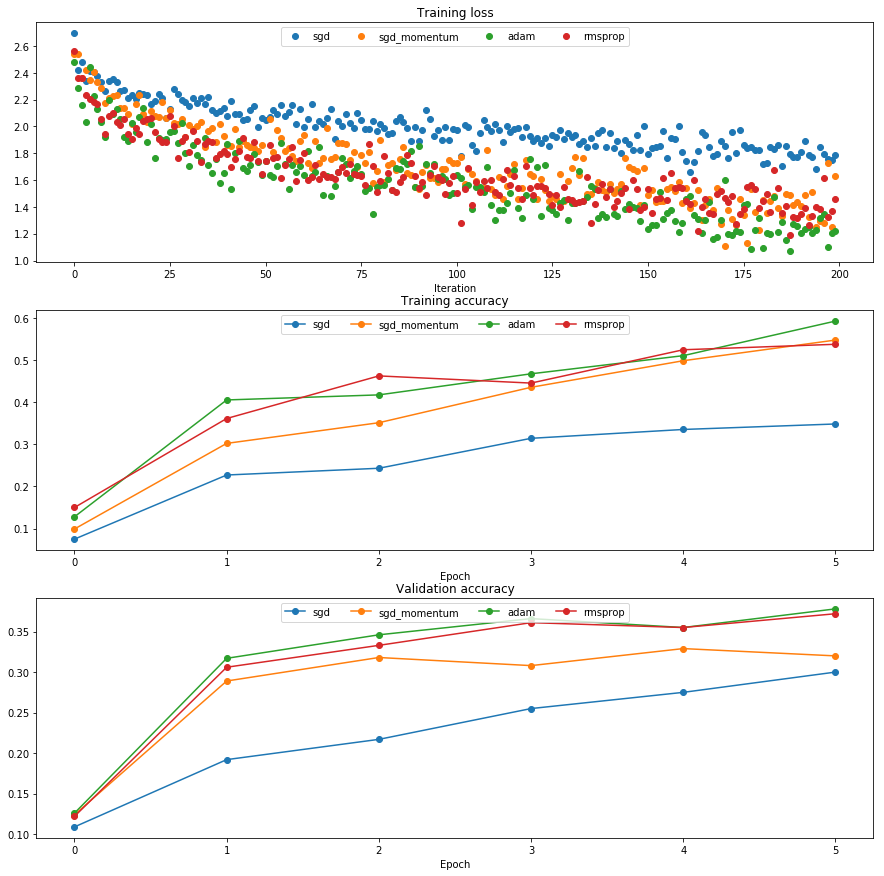

In [78]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochsf=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 3:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?


## Answer: 
- `AdaGrad` <BR>
Weights that receive high gradients, i.e. $dW^2$ is large, get a reduced learning rate consequently. Thus, updates would become very small.
- `Adam` <BR>
Adam uses the following update:
```
m = beta1*m + (1-beta1)*dw
v = beta2*v + (1-beta2)*(dw**2)
w += - learning_rate * m / (np.sqrt(v) + eps)
```

If $dW^2$ is large, it'll be scaled down by a factor of $(1-beta2)$. Therefore, learning rate is not suddenly reduced like in `AdaGrad`.

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [10]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2, \
                          normalization='layernorm')
_data = dict((k, data[k]) for k in ('X_train', 'y_train', 'X_val','y_val'))
solver = Solver(model, _data,
                  num_epochs=10, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3
                  },
                  verbose=True)
solver.train()
best_model = model
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

/Users/hamzaliaqet/Downloads/code/cs233n/assignment2/cs231n/optim.py:162: RuntimeWarning: invalid value encountered in sqrt
  w = w + (-config['learning_rate'] * mt / (np.sqrt(vt) + config['epsilon']))


(Iteration 1 / 4900) loss: 2.368102
(Epoch 0 / 10) train acc: 0.129000; val_acc: 0.138000
(Iteration 11 / 4900) loss: 2.131512
(Iteration 21 / 4900) loss: 1.980108
(Iteration 31 / 4900) loss: 1.919588
(Iteration 41 / 4900) loss: 2.079006
(Iteration 51 / 4900) loss: 1.751431
(Iteration 61 / 4900) loss: 1.908132
(Iteration 71 / 4900) loss: 1.839775
(Iteration 81 / 4900) loss: 1.704517
(Iteration 91 / 4900) loss: 1.862283
(Iteration 101 / 4900) loss: 1.644415
(Iteration 111 / 4900) loss: 1.764693
(Iteration 121 / 4900) loss: 1.690364
(Iteration 131 / 4900) loss: 1.674263
(Iteration 141 / 4900) loss: 1.708684
(Iteration 151 / 4900) loss: 1.780709
(Iteration 161 / 4900) loss: 1.889396
(Iteration 171 / 4900) loss: 1.610676
(Iteration 181 / 4900) loss: 1.784041
(Iteration 191 / 4900) loss: 1.781989
(Iteration 201 / 4900) loss: 1.747947
(Iteration 211 / 4900) loss: 1.606217
(Iteration 221 / 4900) loss: 1.621918
(Iteration 231 / 4900) loss: 1.726385
(Iteration 241 / 4900) loss: 1.718022
(Iterat

(Iteration 2081 / 4900) loss: 1.238823
(Iteration 2091 / 4900) loss: 1.291249
(Iteration 2101 / 4900) loss: 1.274102
(Iteration 2111 / 4900) loss: 1.205802
(Iteration 2121 / 4900) loss: 1.149861
(Iteration 2131 / 4900) loss: 1.213578
(Iteration 2141 / 4900) loss: 1.230866
(Iteration 2151 / 4900) loss: 1.200942
(Iteration 2161 / 4900) loss: 1.158467
(Iteration 2171 / 4900) loss: 1.223417
(Iteration 2181 / 4900) loss: 1.115696
(Iteration 2191 / 4900) loss: 1.341181
(Iteration 2201 / 4900) loss: 1.295959
(Iteration 2211 / 4900) loss: 1.298549
(Iteration 2221 / 4900) loss: 1.253817
(Iteration 2231 / 4900) loss: 1.216056
(Iteration 2241 / 4900) loss: 1.227487
(Iteration 2251 / 4900) loss: 1.270552
(Iteration 2261 / 4900) loss: 1.293394
(Iteration 2271 / 4900) loss: 1.366009
(Iteration 2281 / 4900) loss: 1.281330
(Iteration 2291 / 4900) loss: 1.384143
(Iteration 2301 / 4900) loss: 1.295782
(Iteration 2311 / 4900) loss: 1.320318
(Iteration 2321 / 4900) loss: 1.157060
(Iteration 2331 / 4900) l

(Iteration 4131 / 4900) loss: 0.979710
(Iteration 4141 / 4900) loss: 0.921285
(Iteration 4151 / 4900) loss: 1.137523
(Iteration 4161 / 4900) loss: 1.071169
(Iteration 4171 / 4900) loss: 1.194057
(Iteration 4181 / 4900) loss: 0.996151
(Iteration 4191 / 4900) loss: 1.068004
(Iteration 4201 / 4900) loss: 0.968198
(Iteration 4211 / 4900) loss: 1.151537
(Iteration 4221 / 4900) loss: 1.158882
(Iteration 4231 / 4900) loss: 1.088231
(Iteration 4241 / 4900) loss: 0.920745
(Iteration 4251 / 4900) loss: 0.909968
(Iteration 4261 / 4900) loss: 0.986199
(Iteration 4271 / 4900) loss: 1.053367
(Iteration 4281 / 4900) loss: 1.065726
(Iteration 4291 / 4900) loss: 1.147058
(Iteration 4301 / 4900) loss: 1.055890
(Iteration 4311 / 4900) loss: 0.854618
(Iteration 4321 / 4900) loss: 0.851047
(Iteration 4331 / 4900) loss: 1.140671
(Iteration 4341 / 4900) loss: 1.069446
(Iteration 4351 / 4900) loss: 1.200543
(Iteration 4361 / 4900) loss: 1.000898
(Iteration 4371 / 4900) loss: 0.999756
(Iteration 4381 / 4900) l

# Test your model!
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [11]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.532
Test set accuracy:  0.529
